## 🎓 Sistema de Recomendação de Cursos da Udemy com BM25 e RankT5

Este projeto propõe um sistema híbrido de recomendação de cursos online, combinando técnicas de recuperação de informação com aprendizado supervisionado. A abordagem utiliza:

- 🔍 BM25 para recuperação inicial baseada em similaridade textual
- 🧠 RankT5 (modelo baseado em T5) para reranqueamento supervisionado com entendimento semântico

O objetivo é recomendar cursos mais relevantes com base apenas no título da consulta, simulando um cenário com informações limitadas, como em buscas rápidas feitas por usuários em plataformas educacionais como a Udemy.


### 1. 🛠️ Configuração do NLTK e Stop Words

Nesta etapa inicial, realizamos a preparação do ambiente de processamento de linguagem natural com a biblioteca NLTK. 

Foram baixados os recursos essenciais:
- Tokenizador `punkt` (para dividir textos em palavras)
- Lista de `stopwords` (palavras comuns que não carregam muito significado)

Além das stopwords padrão da língua inglesa, foram adicionadas **stopwords específicas do domínio de cursos de tecnologia**, como "course", "tutorial", "beginner", "bootcamp", entre outras. Isso garante que o modelo se concentre em termos realmente informativos, como linguagens de programação, tecnologias e temas de conteúdo.

Essa filtragem é aplicada durante a tokenização dos títulos dos cursos, melhorando a qualidade da entrada para o cálculo de similaridade com BM25.

In [ ]:
import nltk
import contextlib
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Define um diretório local no projeto
nltk_data_dir = os.path.join(os.getcwd(), "nltk_data")
os.makedirs(nltk_data_dir, exist_ok=True)

nltk.data.path = [nltk_data_dir]  

with open(os.devnull, 'w') as fnull:
    with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
        nltk.download("punkt_tab", download_dir=nltk_data_dir)
        nltk.download("stopwords", download_dir=nltk_data_dir)

stop_words = set(stopwords.words('english'))

extra_stops = {
    "learn", "learning", "course", "courses", "tutorial", "introduction", "intro",
    "guide", "complete", "bootcamp", "beginner", "beginners", "masterclass", "hands-on",
    "project", "projects", "practical", "training", "zero", "hero", "step", "steps",
    "certification", "exam", "pass", "skills", "foundation", "foundations", "build",
    "create", "develop", "start", "basic", "advance", "advanced", "series", "crash",
    "overview", "from", "scratch", "professional", "essentials"
}

custom_stopwords = stop_words.union(extra_stops)

def tokenize_course_title(text):
    tokens = word_tokenize(text.lower())
    return [word for word in tokens if word.isalnum() and word not in custom_stopwords]


### 2. 📥 Importação dos Dados

Nesta etapa, importamos os dados brutos que servirão como base para o sistema de recomendação. Os dados consistem em um arquivo CSV contendo aproximadamente 22 mil títulos de cursos da categoria "IT & Software" da plataforma Udemy, extraído da base pública do Kaggle.

Apenas o campo de título é utilizado, o que simula um cenário desafiador, onde o sistema precisa fazer recomendações sem contar com descrições detalhadas, avaliações de usuários ou outras informações adicionais.

Esses títulos serão utilizados para:
- Construir o índice BM25 para recuperação inicial
- Gerar pares positivos e negativos para o treinamento supervisionado do RankT5


In [44]:
import pandas as pd

print("📂 Carregando cursos da base Udemy...")
df = pd.read_csv("../data/udemy_output_All_IT__Software_p1_p626.csv")
titles = df["title"].dropna().drop_duplicates().tolist()

📂 Carregando cursos da base Udemy...


### 3. 🔗 Geração de Dados para Treinamento do RankT5

Nesta etapa, construímos a base supervisionada necessária para treinar o modelo RankT5. Para isso, utilizamos o algoritmo BM25 para medir a similaridade entre os títulos dos cursos da base da Udemy.

Para cada curso (considerado como consulta), são selecionados:
- **3 pares positivos**: cursos mais semelhantes com base na pontuação do BM25.
- **3 pares negativos**: cursos com baixa similaridade (por exemplo, a partir do 50º resultado).

Cada par é então formatado como uma entrada textual no seguinte padrão:

E recebe um rótulo:
- `"1"` se o par for considerado relevante (positivo)
- `"0"` se o par for irrelevante (negativo)

Esses exemplos textuais são utilizados como entrada para o treinamento supervisionado do modelo RankT5, permitindo que ele aprenda a identificar a relevância entre consultas e cursos com base no texto.



In [45]:
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
from rank_bm25 import BM25Okapi

# Tokenizar os títulos
tokenized_titles = [tokenize_course_title(t) for t in titles]
bm25 = BM25Okapi(tokenized_titles)

print("Calculando matriz de similaridade BM25...")
bm25_matrix = np.array([bm25.get_scores(tokens) for tokens in tqdm(tokenized_titles)])

print("Gerando pares com base nas similaridades BM25...")
pairs = []

for i in tqdm(range(len(titles))):
    scores = bm25_matrix[i]
    sorted_indices = scores.argsort()[::-1]
    sorted_indices = sorted_indices[sorted_indices != i]  # remove o próprio
    
    # Pares positivos (títulos similares) tres mais similares
    positives = sorted_indices[:3]
    # Pares negativos (títulos não similares) tres aleatórios com posições acima de 50 
    negatives = random.sample(list(sorted_indices[50:]), 3) if len(sorted_indices) > 50 else sorted_indices[-3:]

    for j in positives:
        pairs.append((titles[i], titles[j], 1))
    for j in negatives:
        pairs.append((titles[i], titles[j], 0))

# Salvar os pares no formato eperado pelo RankT5
df_pairs = pd.DataFrame(pairs, columns=["query", "course", "label"])
df_pairs.to_csv("../data/bm25_pairs.csv", index=False)

print("Pares salvos em 'bm25_pairs.csv'")

Calculando matriz de similaridade BM25...


100%|██████████| 22750/22750 [03:06<00:00, 122.14it/s]


Gerando pares com base nas similaridades BM25...


100%|██████████| 22750/22750 [00:19<00:00, 1187.19it/s]


Pares salvos em 'bm25_pairs.csv'


### 4. 📊 Divisão dos Dados em Treino e Teste

Antes de treinar o modelo RankT5, é necessário dividir os pares gerados em dois subconjuntos:

- **Conjunto de treinamento (train):** utilizado para ajustar os pesos do modelo supervisionado.
- **Conjunto de teste (test):** utilizado para avaliar a capacidade do modelo em generalizar para exemplos que ele nunca viu.



In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Carregar os pares gerados anteriormente
df = pd.read_csv("../data/bm25_pairs.csv")

# Formatar para RankT5
df_rankt5 = pd.DataFrame({
    "input_text": df.apply(lambda row: f"Query: {row['query']} Course: {row['course']}", axis=1),
    "label": df["label"].astype(str)
})

# Dividir treino e teste
train_df, test_df = train_test_split(df_rankt5, test_size=0.2, random_state=42)

# Salvar os arquivos
train_df.to_csv("../data/rankt5_train.csv", index=False)
test_df.to_csv("../data/rankt5_test.csv", index=False)

print("Arquivos salvos:")
print("rankt5_train.csv")
print("rankt5_test.csv")

Arquivos salvos:
rankt5_train.csv
rankt5_test.csv


### 5. 🧠 Treinamento do Modelo RankT5

Com os dados supervisionados prontos (pares no formato "Query: ... Course: ..." com rótulo 1 ou 0), iniciamos o treinamento do modelo RankT5.

Utilizamos o modelo `t5-small` da biblioteca Hugging Face Transformers como base. Ele é um modelo encoder-decoder, originalmente treinado com a abordagem "texto para texto", o que o torna ideal para tarefas como classificação, tradução, sumarização e, neste caso, reranqueamento supervisionado.

Durante o treinamento:
- O modelo recebe pares de entrada tokenizados com seus rótulos correspondentes.
- Aprende a prever se o curso é ou não relevante para a consulta.
- É ajustado por algumas épocas, utilizando o conjunto completo de dados.
- A performance é monitorada por meio da `validation_loss`, que indica a capacidade do modelo em generalizar para dados que não viu.

Esse processo transforma o T5 em um modelo capaz de entender relações semânticas entre consultas e títulos, indo além da simples similaridade lexical capturada pelo BM25.


In [52]:
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset

# 1. Carregar e amostrar dados
df = pd.read_csv("../data/rankt5_train.csv")
df_test = pd.read_csv("../data/rankt5_test.csv")

train_sample = df
test_sample = df_test

print(f"📚 Dados de treino: {len(train_sample)}")
print(f"🧪 Dados de teste: {len(test_sample)}")

# 2. Tokenizador e modelo
model_name = "t5-small"
print("✂️ Tokenizando dados para entrada no modelo RankT5...")
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# 3. Pré-processamento
def preprocess(line):
    input_text = str(line["input_text"])
    label_text = str(line["label"])

    input_enc = tokenizer(
        input_text,
        padding="max_length",
        truncation=True,
        max_length=64
    )
    label_enc = tokenizer(
        label_text,
        padding="max_length",
        truncation=True,
        max_length=4
    )

    input_enc["labels"] = label_enc["input_ids"]
    return input_enc


train_dataset = Dataset.from_pandas(train_sample).map(
    preprocess, 
    remove_columns=train_sample.columns.tolist()
)

test_dataset = Dataset.from_pandas(test_sample).map(
    preprocess, 
    remove_columns=test_sample.columns.tolist()
)

# 4. Argumentos de treino
training_args = TrainingArguments(
    output_dir="../data/rankt5_output",
    overwrite_output_dir=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    eval_strategy="epoch",  
    save_strategy="epoch",
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=10,
    seed=42,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

# 5. Treinador
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

print("🚀 Iniciando o treinamento supervisionado com RankT5...")
# 6. Treinar o modelo
trainer.train()


📚 Dados de treino: 109200
🧪 Dados de teste: 27300
✂️ Tokenizando dados para entrada no modelo RankT5...


Map: 100%|██████████| 27300/27300 [00:03<00:00, 7277.46 examples/s]


🚀 Iniciando o treinamento supervisionado com RankT5...


Epoch,Training Loss,Validation Loss
1,0.005800,0.012959
2,0.018200,0.013143


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=27300, training_loss=0.034414809940134655, metrics={'train_runtime': 2902.4447, 'train_samples_per_second': 75.247, 'train_steps_per_second': 9.406, 'total_flos': 3694831180185600.0, 'train_loss': 0.034414809940134655, 'epoch': 2.0})

### 6. 🤝 Função de Recomendação Híbrida com BM25 e RankT5

Esta etapa implementa a lógica final do sistema de recomendação, combinando a recuperação inicial com BM25 e o reranqueamento supervisionado com RankT5.

A função híbrida opera em dois estágios:

1. **🔍 Recuperação com BM25 (não supervisionado)**  
   Dada uma consulta (por exemplo, "learn python for data science"), o BM25 busca no corpus os cursos com títulos mais similares, com base na frequência e distribuição dos termos. Os **top-50 cursos mais similares** são selecionados como candidatos iniciais.

2. **🧠 Reranqueamento com RankT5 (supervisionado)**  
   Cada par (consulta + título do curso candidato) é formatado como:  
   Esses pares são passados para o modelo RankT5, que retorna uma pontuação de relevância para cada curso. Os cursos são então **reordenados de acordo com essas pontuações**, priorizando aqueles que o modelo considera semanticamente mais relevantes.

🔁 O resultado final é uma lista de recomendações ordenadas, que combina a eficiência do BM25 com a capacidade semântica do RankT5, entregando sugestões mais precisas e contextualizadas mesmo sem dados de interação do usuário.

 

In [41]:
import torch
from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize
from transformers import T5Tokenizer, T5ForConditionalGeneration

# === Carregar modelo RankT5 já treinado ===
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("../data/rankt5_output/checkpoint-68250") 

tokenized_titles = [tokenize_course_title(t) for t in titles]
bm25 = BM25Okapi(tokenized_titles)

# === Função principal de recomendação híbrida ===
def recommend_courses(query, top_k=5):
    query_tokens = tokenize_course_title(query)
    scores = bm25.get_scores(query_tokens)

    # Top-50 mais relevantes por BM25
    top_50_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:50]
    top_50_courses = [(titles[i], scores[i]) for i in top_50_indices]

    # Criar pares para RankT5
    input_pairs = [f"Query: {query} Course: {course}" for course, _ in top_50_courses]

    # Inferência com RankT5
    rankt5_scores = []
    for text, (title, bm25_score) in zip(input_pairs, top_50_courses):
        inputs = tokenizer(text, return_tensors="pt", truncation=True)
        with torch.no_grad():
            output = model.generate(**inputs)
        prediction = tokenizer.decode(output[0], skip_special_tokens=True)
        score = int(prediction) if prediction.isdigit() else 0
        rankt5_scores.append((title, score, bm25_score))

    # Ordenar pelo score do RankT5 e retornar Top-K
    ranked = sorted(rankt5_scores, key=lambda x: (-x[1], -x[2]))  # primeiro pelo T5, depois BM25
    return ranked[:top_k]

def recommend_and_print(query, top_k=5):
    recommendations = recommend_courses(query, top_k)
    print(f"\n🎯 Recomendação para: '{query}'\n")
    for i, (title, score, bm25_score) in enumerate(recommendations, 1):
        print(f"{i}. {title} (RankT5: {score}, BM25: {bm25_score:.2f})")


### 7. 🧪 Teste da Função de Recomendação Híbrida

Nesta etapa, testamos o sistema de recomendação completo, combinando a recuperação com BM25 e o reranqueamento com RankT5.

In [42]:
recommend_and_print("Python for beginners")
recommend_and_print("Java programming")
recommend_and_print("Machine learning with Python")
recommend_and_print("Web development with JavaScript")
recommend_and_print("Data science and analytics")
recommend_and_print("Cybersecurity")



🎯 Recomendação para: 'Python for beginners'

1. Python for beginners: Learn Python from scratch! (RankT5: 1, BM25: 7.15)
2. Python Complete Course For Python Beginners (RankT5: 1, BM25: 7.15)
3. Python for Beginners: Learn Python Hands-on (Python 3) (RankT5: 1, BM25: 7.06)
4. Python,Python for Beginners Python Real time examples Python (RankT5: 1, BM25: 6.74)
5. Python for Everybody- Learn Python 3 (RankT5: 1, BM25: 6.59)

🎯 Recomendação para: 'Java programming'

1. Java to Develop Programming Skills (RankT5: 1, BM25: 12.13)
2. Java MTA - Introduction to Programming Using Java 98-388 (RankT5: 1, BM25: 10.75)
3. Java Programming: Step by Step from A to Z (RankT5: 1, BM25: 10.73)
4. Object-Oriented Programming in Java: From the Beginning (RankT5: 1, BM25: 10.73)
5. Ultimate Java Programming for Beginners (RankT5: 1, BM25: 10.73)

🎯 Recomendação para: 'Machine learning with Python'

1. Hands-On Machine Learning with scikit-learn and Python (RankT5: 1, BM25: 12.76)
2. Introduction To Mach

In [43]:
import pandas as pd
from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize
from sklearn.metrics import ndcg_score
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
import re

# --- 1. Carrega os dados ---
df_test = pd.read_csv("../data/rankt5_test.csv")
df_test["query"] = df_test["input_text"].str.extract(r"Query: (.*?) Course:")
df_test["course"] = df_test["input_text"].str.extract(r"Course: (.*)")

# --- 2. Prepara título dos cursos para BM25 ---
titles = df_test["course"].unique().tolist()
tokenized_titles = [tokenize_course_title(t) for t in titles]
bm25 = BM25Okapi(tokenized_titles)

# --- 3. Previsões com RankT5 ---
tokenizer = T5Tokenizer.from_pretrained("t5-small", legacy=True)
model = T5ForConditionalGeneration.from_pretrained("../data/rankt5_output/checkpoint-68250")
model.eval()


def predict_score(text):
    input_ids = tokenizer.encode(text, return_tensors="pt", truncation=True, max_length=64)
    with torch.no_grad():
        outputs = model.generate(input_ids, max_length=4, return_dict_in_generate=True)
        decoded = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
        return 1.0 if decoded.strip() == "1" else 0.0


df_test["rankt5_score"] = df_test["input_text"].apply(predict_score)

# --- 4. Agrupa pares reais por query ---
query_labels = df_test.groupby("query", group_keys=False).apply(
    lambda g: dict(zip(g["course"], g["label"])),
    include_groups=False
).to_dict()

# --- 5. Avaliação comparativa ---
results = []

for query, relevant_courses in query_labels.items():
    if sum(relevant_courses.values()) == 0 or len(relevant_courses) < 2:
        continue

    # --- BM25 ---
    tokenized_query = tokenize_course_title(query)
    scores_bm25 = bm25.get_scores(tokenized_query)
    top_indices = scores_bm25.argsort()[::-1][:len(relevant_courses)]
    top_courses_bm25 = [titles[i] for i in top_indices]
    y_true_bm25 = [relevant_courses.get(c, 0) for c in top_courses_bm25]
    y_score_bm25 = [1.0 / (i + 1) for i in range(len(y_true_bm25))]  # decrescendo

    ndcg_bm25 = ndcg_score([y_true_bm25], [y_score_bm25], k=5)

    # --- RankT5 ---
    group = df_test[df_test["query"] == query]
    group_sorted = group.sort_values(by="rankt5_score", ascending=False)
    y_true_rankt5 = group_sorted["label"].tolist()
    y_score_rankt5 = group_sorted["rankt5_score"].tolist()
    ndcg_rankt5 = ndcg_score([y_true_rankt5], [y_score_rankt5], k=5)

    results.append({
        "query": query,
        "nDCG@5_RankT5": ndcg_rankt5,
        "nDCG@5_BM25": ndcg_bm25
    })

# --- 6. Mostra a tabela de comparação ---
df_results = pd.DataFrame(results)
df_results["melhor_modelo"] = df_results.apply(
    lambda row: "RankT5" if row["nDCG@5_RankT5"] > row["nDCG@5_BM25"]
    else "BM25" if row["nDCG@5_BM25"] > row["nDCG@5_RankT5"]
    else "Empate", axis=1
)



#### 8.1 📊 Comparativo entre as médias de nDCG@5 de RankT5 e BM25


📈 Média global nDCG@5 - RankT5: 0.9923
📊 Média global nDCG@5 - BM25:    0.3435


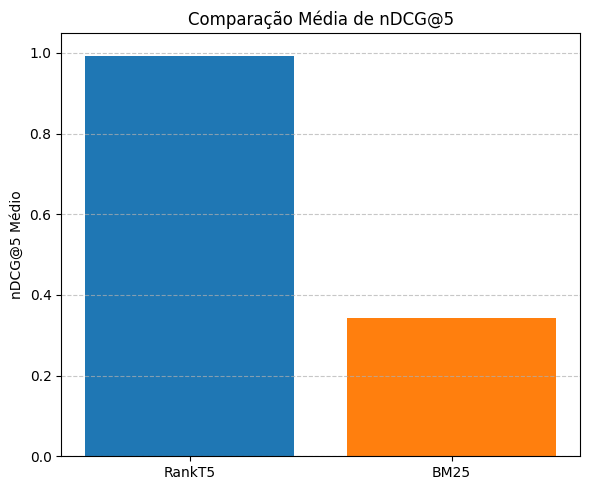

In [45]:

import matplotlib.pyplot as plt

media_rankt5 = df_results["nDCG@5_RankT5"].mean()
media_bm25 = df_results["nDCG@5_BM25"].mean()

print(f"\n📈 Média global nDCG@5 - RankT5: {media_rankt5:.4f}")
print(f"📊 Média global nDCG@5 - BM25:    {media_bm25:.4f}")

plt.figure(figsize=(6, 5))
plt.bar(["RankT5", "BM25"], [media_rankt5, media_bm25], color=["#1f77b4", "#ff7f0e"])
plt.ylabel("nDCG@5 Médio")
plt.title("Comparação Média de nDCG@5")
plt.ylim(0, 1.05)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### 8.2 📊 Comparação de nDCG@5 - RankT5 vs BM25 (amostra)

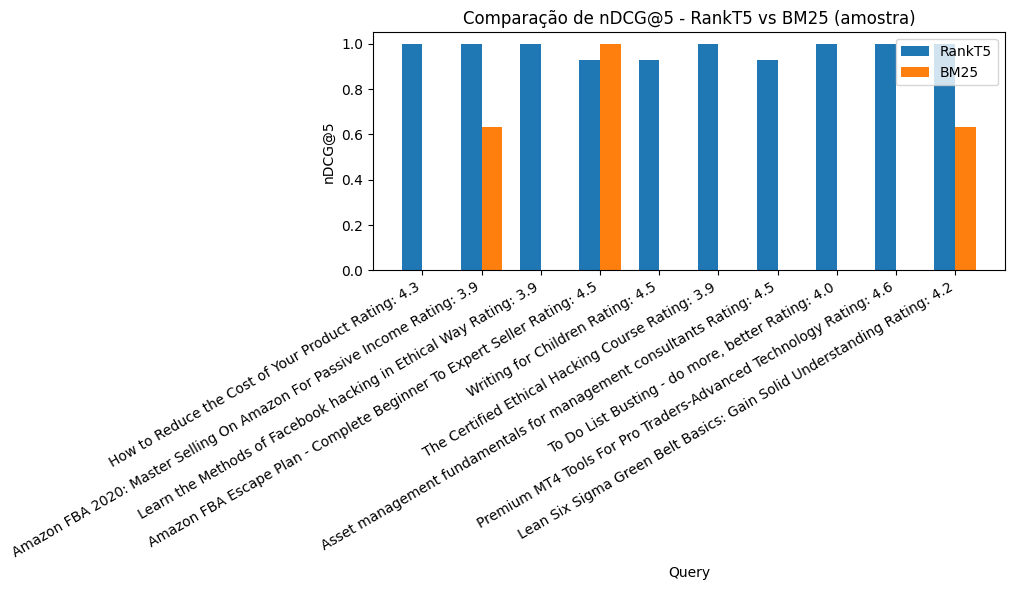

In [46]:
import matplotlib.pyplot as plt

sample_df = df_results.sample(10)

bar_width = 0.35
index = range(len(sample_df))

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width / 2 for i in index], sample_df["nDCG@5_RankT5"], width=bar_width, label="RankT5")
plt.bar([i + bar_width / 2 for i in index], sample_df["nDCG@5_BM25"], width=bar_width, label="BM25")

plt.xlabel("Query")
plt.ylabel("nDCG@5")
plt.title("Comparação de nDCG@5 - RankT5 vs BM25 (amostra)")
plt.xticks(index, sample_df["query"], rotation=30, ha="right")
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()

plt.show()